In [ ]:
#import bibliotek
import pandas as pd
import numpy as np
import importlib
import json
from catboost import CatBoostClassifier #trzeba zainstalowac sobie
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline # moduł pipeline
from sklearn.impute import SimpleImputer # moduł imputacji braków danych
from sklearn.preprocessing import OneHotEncoder, StandardScaler # moduł przetwarzania danych
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, log_loss, balanced_accuracy_score
import importlib
from sklearn.base import BaseEstimator
from sklearn.utils import shuffle
import inspect
import copy
import kagglehub
from pathlib import Path
import openml
import time

In [ ]:
path = kagglehub.dataset_download("mi2datalab/mementoml")
DATA_DIR = Path(path)
csv_files = sorted(DATA_DIR.rglob("*.csv"))

dfs = []
for f in csv_files:
    d = pd.read_csv(f)
    d["__source_file"] = f.name
    dfs.append(d)

df = pd.concat(dfs, ignore_index=True)
df = df.loc[:, ["model", "param_index", "dataset", "row_index", "acc", "auc"]]
df.shape
df.head(21)

,model,param_index,dataset,row_index,acc,auc
0,catboost,1001.0,1485.0,1.0,0.540385,0.908843
1,catboost,1001.0,1485.0,2.0,0.507692,0.931537
2,catboost,1001.0,1485.0,3.0,0.498077,0.941005
3,catboost,1001.0,1485.0,4.0,0.494231,0.909722
4,catboost,1001.0,1485.0,5.0,0.513462,0.926722
5,catboost,1001.0,1485.0,6.0,0.517308,0.917742
6,catboost,1001.0,1485.0,7.0,0.463462,0.903538
7,catboost,1001.0,1485.0,8.0,0.505769,0.911586
8,catboost,1001.0,1485.0,9.0,0.505769,0.902739
9,catboost,1001.0,1485.0,10.0,0.538462,0.932872


## **Etap 1** - przygotowanie portfolio na podstawie zbioru MementoML


In [ ]:
#wczytanie danych
rf_params = pd.read_csv("randomForest_params.csv")
catboost_params = pd.read_csv("catboost_params.csv")
xgboost_params = pd.read_csv("xgboost_params.csv")
gbm_params = pd.read_csv("gbm_params.csv")
glmnet_params = pd.read_csv("glmnet_params.csv")
kknn_params = pd.read_csv("kknn_params.csv")
ranger_params = pd.read_csv("ranger_params.csv")


In [ ]:
df = df.dropna()
#zmiana tych indeksów, które są mniejsze od 1000 (nie powinno tak być) na indeks + 1000
mask = df["param_index"] < 1000
df.loc[mask, "param_index"] = df.loc[mask, "param_index"] + 1000

In [ ]:
#średnia po row_index
per_dataset = (
    df.groupby(["model", "param_index", "dataset"], as_index=False)
      .agg(acc_dataset=("acc", "mean"))
)

#średnia po datasetach
ranking_cfg = (
    per_dataset.groupby(["model", "param_index"], as_index=False)
               .agg(
                   mean_acc=("acc_dataset", "mean"),
                   std_acc=("acc_dataset", "std"),
                   median_acc=("acc_dataset", "median"),
                   n_datasets=("dataset", "nunique")
               )
)

# Mediana odchylen dla modelow, tam gdzie jest policzalna - potrzebna do kary w przypadku gdy n_datasets = 1 i wtedy std = 0
std_ref_by_model = (
    ranking_cfg.loc[ranking_cfg["n_datasets"] > 1]
    .groupby("model")["std_acc"]
    .median()
)

ranking_cfg["std_for_score"] = ranking_cfg["std_acc"]

mask = (ranking_cfg["n_datasets"] == 1) & (ranking_cfg["std_for_score"].isna())
ranking_cfg.loc[mask, "std_for_score"] = ranking_cfg.loc[mask, "model"].map(std_ref_by_model)

LAMBDA = 0.8   # kara za niestabilność
GAMMA  = 0.03  # bonus za liczbę datasetów

# dodanie kolumny score
ranking_cfg["score"] = (
    0.6 * ranking_cfg["mean_acc"]
    + 0.4 * ranking_cfg["median_acc"]
    - LAMBDA * ranking_cfg["std_for_score"].fillna(0.0)
    + GAMMA * np.log(ranking_cfg["n_datasets"])
)

#sortowanie po score
ranking_cfg = ranking_cfg.sort_values(
    ["score"],
    ascending=False
).reset_index(drop=True)


In [ ]:
#ranking ogólny rodzin
family_summary = (
    ranking_cfg
    .groupby("model", as_index=False)
    .agg(
        mean_score=("score", "mean"),
        mean_acc=("mean_acc", "mean"),
        median_acc=("mean_acc", "median"),
        best_acc=("mean_acc", "max"),
        mean_std_acc=("std_acc", "mean"),
        mean_n_datasets=("n_datasets", "mean"),
        n_configs=("param_index", "count")
    )
    .sort_values("mean_score", ascending=False)
)

family_summary


,model,mean_score,mean_acc,median_acc,best_acc,mean_std_acc,mean_n_datasets,n_configs
7,ranger,0.932363,0.894790,0.894733,0.900952,0.102473,35.088000,1000
6,randomForest,0.924806,0.893359,0.893585,0.897665,0.100249,32.894000,1000
9,xgboost,0.898038,0.982768,0.992654,0.995207,0.117038,2.148718,195
0,agtboost,0.890818,0.950353,0.945386,0.983971,0.092218,1.714588,473
3,gbm,0.888531,0.863300,0.870638,0.899927,0.114071,33.754000,1000
5,kknn,0.887967,0.857371,0.861546,0.867053,0.111894,37.931000,1000
8,svm,0.804055,0.797225,0.820913,0.852594,0.141463,39.000000,11
4,glmnet,0.745286,0.751884,0.690677,0.847533,0.142867,38.034000,1000
1,bartMachine,0.670416,0.687105,0.633020,0.857842,0.081869,4.363636,11
2,catboost,0.634766,0.735793,0.798364,0.848047,0.178729,4.436000,1000


In [ ]:
#ustawienie po ile modeli chcemy mieć w portfolio z danej rodziny

#można sobie zmieniać wg życzenia i potrzeby
model_limits = {
    "ranger": 0,
    "randomForest": 0,
    "xgboost": 8,
    "gbm": 8,
    "kknn": 8,
    "glmnet": 6,
    #"svm":  fajnie by było mieć, ale nie ma dla tego pliku svm_params
}

datasets_by_model = {}

MAX_N1 = 4  # maksymalnie tyle konfiguracji z n_datasets = 1 w top-k dla danego modelu

for model, k in model_limits.items():
    k_zab = k + 10      # Zabiezpieczenie ze wzgledu na mozliwe duplikaty rzeczywistych parametrow dla roznych param_index
    df_m = ranking_cfg[ranking_cfg["model"] == model].copy()

    # sortuj po score malejąco, potem po liczbie datasetow malejaco i stabilnosci rosnaco
    df_m = df_m.sort_values(
        ["score", "n_datasets", "std_acc"],
        ascending=[False, False, True]
    )

    # bierz do MAX_N1 z n_datasets = 1
    df_n1 = df_m[df_m["n_datasets"] == 1].head(min(MAX_N1, k_zab))

    # reszta miejsc: tylko n_datasets > 1
    df_rest = df_m[df_m["n_datasets"] > 1].head(max(0, k_zab - len(df_n1)))

    df_model = pd.concat([df_n1, df_rest], ignore_index=True)

    datasets_by_model[model] = df_model.reset_index(drop=True)


In [ ]:
#rankingi najlpeszcych konfiguracji dla każdej rodziny modeli
rf_rank        = datasets_by_model["randomForest"]
ranger_rank    = datasets_by_model["ranger"]
gbm_rank       = datasets_by_model["gbm"]
xgboost_rank   = datasets_by_model["xgboost"]
glmnet_rank    = datasets_by_model["glmnet"]
kknn_rank      = datasets_by_model["kknn"]

In [ ]:
# mapowanie po param_idx aby uzyskać hiperparametry, usuwanie duplikatow
def drop_dups(df, key="param_index"):
    cols = [c for c in df.columns if c != key]
    return df.drop_duplicates(subset=cols, keep="first").reset_index(drop=True)

rf_k = model_limits["randomForest"]
gbm_k = model_limits["gbm"]
xgb_k = model_limits["xgboost"]
kknn_k = model_limits["kknn"]
ranger_k = model_limits["ranger"]
glmnet_k = model_limits["glmnet"]

rf_merged = drop_dups(
    rf_rank.merge(rf_params, on="param_index", how="left")
).head(rf_k).reset_index(drop=True)

gbm_merged = drop_dups(
    gbm_rank.merge(gbm_params, on="param_index", how="left")
).head(gbm_k).reset_index(drop=True)

xgboost_merged = drop_dups(
    xgboost_rank.merge(xgboost_params, on="param_index", how="left")
).head(xgb_k).reset_index(drop=True)

kknn_merged = drop_dups(
    kknn_rank.merge(kknn_params, on="param_index", how="left")
).head(kknn_k).reset_index(drop=True)

ranger_merged = drop_dups(
    ranger_rank.merge(ranger_params, on="param_index", how="left")
).head(ranger_k).reset_index(drop=True)

glmnet_merged = drop_dups(
    glmnet_rank.merge(glmnet_params, on="param_index", how="left")
).head(glmnet_k).reset_index(drop=True)


In [ ]:
#przykład jak wygląda jedna z tych df
glmnet_merged

,model,param_index,mean_acc,std_acc,median_acc,n_datasets,std_for_score,score,alpha,lambda
0,glmnet,1769.0,0.847533,0.121269,0.867477,38,0.121269,0.867624,0.422439,0.003716
1,glmnet,1609.0,0.846684,0.122260,0.868188,38,0.122260,0.866605,0.441774,0.003218
2,glmnet,1580.0,0.846728,0.122558,0.867408,38,0.122558,0.866081,0.570541,0.002550
3,glmnet,1040.0,0.846193,0.123023,0.868070,38,0.123023,0.865653,0.611779,0.003213
4,glmnet,1746.0,0.844349,0.123601,0.867888,38,0.123601,0.864011,0.410306,0.002427
5,glmnet,1943.0,0.844503,0.124185,0.868669,38,0.124185,0.863949,0.072402,0.002045


##**Etap 2** Zapis modeli do pliku models.json

In [ ]:
#trzeba było zmieniać z R nazw parametrów na pythonowe
portfolio = []

#randomforest
for _, row in rf_merged.iterrows():
    params = {}


    params["n_estimators"] = int(row["ntree"])

    # bootstrap (domyślnie True)
    if bool(row["replace"]) != True:
        params["bootstrap"] = bool(row["replace"])

    # min_samples_leaf (domyślnie 1)
    if int(row["nodesize"]) != 1:
        params["min_samples_leaf"] = int(row["nodesize"])

    portfolio.append({
        "name": f"randomForest_{int(row['param_index'])}",
        "class": "sklearn.ensemble.RandomForestClassifier",
        "params": params
    })


#gbm
for _, row in gbm_merged.iterrows():
    params = {}

    params["max_iter"] = int(row["n.trees"])

    # interaction.depth -> max_depth
    if not pd.isna(row["interaction.depth"]):
        params["max_depth"] = int(row["interaction.depth"])

    # n.minobsinnode -> min_samples_leaf
    if int(row["n.minobsinnode"]) != 20:
        params["min_samples_leaf"] = int(row["n.minobsinnode"])

    # shrinkage -> learning_rate
    if float(row["shrinkage"]) != 0.1:
        params["learning_rate"] = float(row["shrinkage"])

    # bag.fraction -> subsample (nie ma tego w HistGradientBoostingClassifier)
    # if float(row["bag.fraction"]) != 1.0:
    #    params["subsample"] = float(row["bag.fraction"])

    portfolio.append({
        "name": f"gbm_{int(row['param_index'])}",
        "class": "sklearn.ensemble.HistGradientBoostingClassifier",
        "params": params
    })

#xgboost
DEFAULTS = {
    "booster": "gbtree",
    "n_estimators": 100,
    "learning_rate": 0.3,
    "subsample": 1.0,
    "max_depth": 6,
    "min_child_weight": 1.0,
    "colsample_bytree": 1.0,
    "colsample_bylevel": 1.0,
    "missing": float("nan")  # w xgboost domyślnie None/np.nan
}

for _, row in xgboost_merged.iterrows():
    params = {}

    # wymagane / sensowne ustawienia dla binarnej klasyfikacji i AUC
    params["objective"] = "binary:logistic"
    params["eval_metric"] = "auc"

    # booster
    if "booster" in row and pd.notna(row["booster"]) and row["booster"] != DEFAULTS["booster"]:
        params["booster"] = str(row["booster"])

    # nrounds -> n_estimators
    if "nrounds" in row and pd.notna(row["nrounds"]):
        n_estimators = int(row["nrounds"])
        if n_estimators != DEFAULTS["n_estimators"]:
            params["n_estimators"] = n_estimators

    # eta -> learning_rate
    if "eta" in row and pd.notna(row["eta"]):
        lr = float(row["eta"])
        if lr != DEFAULTS["learning_rate"]:
            params["learning_rate"] = lr

    # subsample
    if "subsample" in row and pd.notna(row["subsample"]):
        subs = float(row["subsample"])
        if subs != DEFAULTS["subsample"]:
            params["subsample"] = subs

    # max_depth
    if "max_depth" in row and pd.notna(row["max_depth"]):
        md = int(row["max_depth"])
        if md != DEFAULTS["max_depth"]:
            params["max_depth"] = md

    # min_child_weight
    if "min_child_weight" in row and pd.notna(row["min_child_weight"]):
        mcw = float(row["min_child_weight"])
        if mcw != DEFAULTS["min_child_weight"]:
            params["min_child_weight"] = mcw

    # colsample_bytree
    if "colsample_bytree" in row and pd.notna(row["colsample_bytree"]):
        csbt = float(row["colsample_bytree"])
        if csbt != DEFAULTS["colsample_bytree"]:
            params["colsample_bytree"] = csbt

    # colsample_bylevel
    if "colsample_bylevel" in row and pd.notna(row["colsample_bylevel"]):
        csbl = float(row["colsample_bylevel"])
        if csbl != DEFAULTS["colsample_bylevel"]:
            params["colsample_bylevel"] = csbl

    # missing
    if "missing" in row and pd.notna(row["missing"]):
        miss = float(row["missing"])
        # jeśli missing != default (zwykle nie trzeba, ale skoro masz w tabeli, zachowujemy)
        # xgboost pozwala na missing=0 itp.
        params["missing"] = miss

    portfolio.append({
        "name": f"xgboost_{int(row['param_index'])}",
        "class": "xgboost.XGBClassifier",
        "params": params
    })

# zapis
with open("models.json", "w", encoding="utf-8") as f:
    json.dump(portfolio, f, indent=2, ensure_ascii=False)

#kknn
for _, row in kknn_merged.iterrows():
    params = {}

    # k -> n_neighbors (default 5)
    if int(row["k"]) != 5:
        params["n_neighbors"] = int(row["k"])

    # distance -> p (default 2)
    # (w kknn: 1=Manhattan, 2=Euclidean)
    if int(row["distance"]) != 2:
        params["p"] = int(row["distance"])
        params["metric"] = "minkowski"



    portfolio.append({
        "name": f"kknn_{int(row['param_index'])}",
        "class": "sklearn.neighbors.KNeighborsClassifier",
        "params": params
    })

# glmnet
for _, row in glmnet_merged.iterrows():
    params = {}

    alpha = float(row["alpha"])
    lmbd = float(row["lambda"])

    # lambda -> C
    if lmbd > 0:
        C = 1.0 / lmbd
        params["C"] = C

    # alpha -> penalty
    if np.isclose(alpha, 0.0):
        params["penalty"] = "l2"
    elif np.isclose(alpha, 1.0):
        params["penalty"] = "l1"
        params["solver"] = "saga"
    else:
        params["penalty"] = "elasticnet"
        params["l1_ratio"] = alpha
        params["solver"] = "saga"

    portfolio.append({
        "name": f"glmnet_{int(row['param_index'])}",
        "class": "sklearn.linear_model.LogisticRegression",
        "params": params
    })

# ranger -> RandomForestClassifier (sklearn)
for _, row in ranger_merged.iterrows():
    params = {}

    # num.trees -> n_estimators (default 100)
    if int(row["num.trees"]) != 100:
        params["n_estimators"] = int(row["num.trees"])

    # min.node.size -> min_samples_leaf (default 1)
    if int(row["min.node.size"]) != 1:
        params["min_samples_leaf"] = int(row["min.node.size"])

    # replace -> bootstrap (default True)
    if bool(row["replace"]) != True:
        params["bootstrap"] = bool(row["replace"])


    portfolio.append({
        "name": f"ranger_{int(row['param_index'])}",
        "class": "sklearn.ensemble.RandomForestClassifier",
        "params": params
    })

In [ ]:
# Wybrane przykładowe konfiguracje lasu losowego wzięte ręcznie z artykułow na temat optymalizacji hiperparametrów RF
random_forest_configs = [
    {
        'name': 'rf_800_sqrt_2',
        'class': 'sklearn.ensemble.RandomForestClassifier',
        'params': {
            'n_estimators': 800,
            'max_features': 'sqrt',
            'min_samples_leaf': 2,
            'bootstrap': True,
            'max_depth': None,
            'criterion': 'gini'
        }
    },
    {
        'name': 'rf_500_log2_1',
        'class': 'sklearn.ensemble.RandomForestClassifier',
        'params': {
            'n_estimators': 500,
            'max_features': 'log2',
            'min_samples_leaf': 1,
            'bootstrap': True,
            'max_depth': None,
            'criterion': 'gini'
        }
    },
    {
        'name': 'rf_1200_sqrt_4',
        'class': 'sklearn.ensemble.RandomForestClassifier',
        'params': {
            'n_estimators': 1200,
            'max_features': 'sqrt',
            'min_samples_leaf': 4,
            'bootstrap': True,
            'max_depth': None,
            'criterion': 'entropy'
        }
    },
    {
        'name': 'rf_600_0.5_2',
        'class': 'sklearn.ensemble.RandomForestClassifier',
        'params': {
            'n_estimators': 600,
            'max_features': 0.5,
            'min_samples_leaf': 2,
            'bootstrap': True,
            'max_depth': None,
            'criterion': 'gini'
        }
    },
    {
        'name': 'rf_1500_sqrt_3',
        'class': 'sklearn.ensemble.RandomForestClassifier',
        'params': {
            'n_estimators': 1500,
            'max_features': 'sqrt',
            'min_samples_leaf': 3,
            'bootstrap': True,
            'max_depth': None,
            'criterion': 'entropy'
        }
    },]

for config in random_forest_configs:
    portfolio.append(config)

In [ ]:
#zapis do pliku
with open("models.json", "w", encoding="utf-8") as f:
    json.dump(portfolio, f, indent=2, ensure_ascii=False)

In [ ]:
MODELS_PATH = Path("models.json")
with MODELS_PATH.open("r", encoding="utf-8") as f:
    models_json = json.load(f)

In [ ]:
# Główny kod systemu
def create_estimator(class_path: str, params: dict):
    """
    Tworzy model (jako obiekt) zachowując standardy bezpieczeństwa (żeby nie robić eval(podejrzany_string))
    """
    if class_path.startswith("sklearn."):
        allowed_lib = "sklearn"
    elif class_path.startswith("catboost."):
        allowed_lib = "catboost"
    elif class_path.startswith("xgboost."):
        allowed_lib = "catboost"
    else:
        raise ValueError("Only sklearn and catboost estimators are allowed")

    module_path, class_name = class_path.rsplit(".", 1)

    module = importlib.import_module(module_path)
    cls = getattr(module, class_name)

    # sklearn
    if allowed_lib == "sklearn":
        if not issubclass(cls, BaseEstimator):
            raise TypeError("Not a valid sklearn estimator")

    # catboost
    if allowed_lib == "catboost":
        if not hasattr(cls, "fit"):
            raise TypeError("Not a valid catboost estimator")

    # xgboost
    if allowed_lib == "xgboost":
        if not hasattr(cls, "fit"):
            raise TypeError("Not a valid xgboost estimator")

    return cls(**params)


def add_random_state_if_supported(class_path: str, params: dict, random_state=42):
    """
    Dodaje parametr random_state do modelu jeśli jest obsługiwany w celu replikowalności wyników
    """
    module_path, class_name = class_path.rsplit(".", 1)
    module = __import__(module_path, fromlist=[class_name])
    cls = getattr(module, class_name)

    sig = inspect.signature(cls.__init__)
    params_in_init = list(sig.parameters.keys())

    if "random_seed" in params or "random_state" in params:
        return params

    if "random_seed" in params_in_init and "random_seed" not in params:
        params["random_seed"] = random_state
    elif "random_state" in params_in_init and "random_state" not in params:
        params["random_state"] = random_state

    return params


class MiniAutoML:
    def __init__(self, n_folds="auto", models_config=models_json, random_state=42, print_fit=True):
        assert n_folds is not None, "n_folds ma być 'auto' lub dodatnie calkowite"
        # Podział modeli ze względu na klasę
        models_config = copy.deepcopy(models_config)
        models_by_class = {}
        for model in models_config:
            if "verbose" in model["params"]:
                model["params"]["verbose"] = None
            if model["class"] not in models_by_class.keys():
                models_by_class[model["class"]] = [(model["name"], model["params"])]
            else:
                models_by_class[model["class"]].append((model["name"], model["params"]))

        self.models_by_class = models_by_class
        self.models_fitted = None
        self.n_folds = n_folds
        self.random_state = random_state
        self.print_fit = print_fit

        # Pipeline do przetwarzania danych
        num_pipeline = Pipeline(steps=[
            ('impute', SimpleImputer(strategy="median")),
            ('scale', StandardScaler())
            ])

        cat_pipeline= Pipeline(steps = [
                ('impute', SimpleImputer(strategy='most_frequent')),
                ('one_hot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
        ])

        self.transformator = ColumnTransformer(
            transformers=[
            (
                "numeric_preprocessing",
                num_pipeline,
                make_column_selector(dtype_include=np.number),
            ),
            (
                "categorical_preprocessing",
                cat_pipeline,
                make_column_selector(dtype_include=['object', 'category', "string"]),
            ),
            ],
        remainder="passthrough",
        )


    def fit(self, X_train, y_train):
        # Heurystyka wyboru n_folds
        if self.n_folds == "auto":
            n_samples = X_train.shape[0]
            if n_samples < 100:
                self.n_folds = 3
            elif 100 <= n_samples < 10000:
                self.n_folds = 5
            else:
                self.n_folds = 10

        # Ewaluacja modeli przez kross-walidację
        rows = []
        for model_class, model_instances in self.models_by_class.items():
            for model_name, model_params in model_instances:
                model_params = add_random_state_if_supported(model_class, model_params.copy(), self.random_state)
                model = create_estimator(model_class, model_params)
                pipe = Pipeline(steps=[
                    ("preprocess", self.transformator),
                    ("clf", model)
                ])
                cv = StratifiedKFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)
                start = time.time()
                mean_auc = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
                end = time.time()
                if self.print_fit:
                    print(f"Cross_val_score - {model_name}: AUC={mean_auc:.4f}, Time={end - start:.2f}s")
                rows.append({
                    "model_name": model_name,
                    "model_class": model_class,
                    "mean_auc": mean_auc,
                    "model_params": model_params,
                })

        # Wybór najlepszych modeli z każdej klasy
        leaderboard = pd.DataFrame(rows)
        self.leaderboard = leaderboard.sort_values("mean_auc", ascending=False).reset_index(drop=True)
        best_model_rows = []
        for model_class in self.models_by_class.keys():
            leaderboard_class = leaderboard[leaderboard["model_class"] == model_class]
            leaderboard_class = leaderboard_class.sort_values("mean_auc", ascending=False).reset_index(drop=True)
            best_model_class = leaderboard_class.iloc[0, :]
            best_model_rows.append(best_model_class)
        best_models_df = pd.DataFrame(best_model_rows)
        best_models_df = best_models_df.sort_values("mean_auc", ascending=False).reset_index(drop=True)
        models_selected = best_models_df.iloc[0:(min(5, len(best_models_df))), :]
        self.selected_models_leaderboard = models_selected

        # Fitting finalnego modelu VotingClassifier
        final_model = VotingClassifier(
            estimators=[
                (row["model_name"], Pipeline(steps=[("preprocess", self.transformator), ("clf", create_estimator(row["model_class"], row["model_params"]))]))
                for _, row in models_selected.iterrows()
            ],
            voting="soft",
        )
        start_final = time.time()
        final_model.fit(X_train, y_train)
        end_final = time.time()
        if self.print_fit:
            print(f"Final model fitted in {end_final - start_final:.2f}s")
        self.models_fitted = final_model.estimators_
        self.final_model = final_model


    def predict(self, X_test):
        return self.final_model.predict(X_test)


    def predict_proba(self, X_test):
        # zwraca prawdopodobieństwa dla klasy pozytywnej (1)
        return self.final_model.predict_proba(X_test)[:, 1]


In [ ]:
# Przykładowe dane z githuba przedmiotu
X = pd.read_csv("X.csv")
y = pd.read_csv("y.csv")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
automl = MiniAutoML(n_folds="auto", models_config = models_json)

In [ ]:
automl.fit(X_train, y_train)

Cross_val_score - gbm_1403: AUC=0.5475, Time=5.92s
Cross_val_score - gbm_1323: AUC=0.5505, Time=3.50s
Cross_val_score - gbm_1184: AUC=0.5501, Time=2.81s
Cross_val_score - gbm_1521: AUC=0.5447, Time=4.24s
Cross_val_score - gbm_1667: AUC=0.5407, Time=4.47s
Cross_val_score - gbm_1628: AUC=0.5497, Time=1.62s
Cross_val_score - gbm_1556: AUC=0.5393, Time=3.97s
Cross_val_score - gbm_1363: AUC=0.5424, Time=3.16s
Cross_val_score - xgboost_1049: AUC=0.5552, Time=0.41s
Cross_val_score - xgboost_1070: AUC=0.5644, Time=0.55s
Cross_val_score - xgboost_1109: AUC=0.5534, Time=0.42s
Cross_val_score - xgboost_1160: AUC=0.5578, Time=0.91s
Cross_val_score - xgboost_1011: AUC=0.5529, Time=0.06s
Cross_val_score - xgboost_1005: AUC=0.5530, Time=0.09s
Cross_val_score - xgboost_1006: AUC=0.5647, Time=0.24s
Cross_val_score - xgboost_1009: AUC=0.5613, Time=0.89s
Cross_val_score - kknn_1007: AUC=0.5595, Time=0.08s
Cross_val_score - kknn_1976: AUC=0.5666, Time=0.07s
Cross_val_score - kknn_1967: AUC=0.5553, Time=0.

c:\Users\frane\miniforge3\envs\MLenv_fixed\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\frane\miniforge3\envs\MLenv_fixed\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Final model fitted in 15.35s


In [ ]:
preds = automl.predict(X_test)
probas = automl.predict_proba(X_test)
accuracy_score(y_test, preds), roc_auc_score(y_test, probas)

(0.5652797704447633, np.float64(0.5636909984934024))

In [ ]:
automl.models_by_class
automl.n_folds
automl.models_fitted
automl.final_model

VotingClassifier(estimators=[('rf_1500_sqrt_3',
                              Pipeline(steps=[('preprocess',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('numeric_preprocessing',
                                                                                Pipeline(steps=[('impute',
                                                                                                 SimpleImputer(strategy='median')),
                                                                                                ('scale',
                                                                                                 StandardScaler())]),
                                                                                <sklearn.compose._column_transformer.make_column_selector object at 0x00000235396B5520>),
                                                                               ('categorical_pre...
                                                                                                 SimpleImputer(strategy='most_frequent')),
                                                                                                ('one_hot',
                                                                                                 OneHotEncoder(drop='first',
                                                                                                               handle_unknown='ignore',
                                                                                                               sparse_output=False))]),
                                                                                <sklearn.compose._column_transformer.make_column_selector object at 0x000002353AEA4CB0>)])),
                                              ('clf',
                                               HistGradientBoostingClassifier(learning_rate=0.0893436294508293,
                                                                              max_depth=5,
                                                                              max_iter=4305,
                                                                              min_samples_leaf=8,
                                                                              random_state=42))]))],
                 voting='soft')

In [ ]:
automl.leaderboard

,model_name,model_class,mean_auc,model_params
0,rf_1500_sqrt_3,sklearn.ensemble.RandomForestClassifier,0.573692,"{'n_estimators': 1500, 'max_features': 'sqrt',..."
1,rf_800_sqrt_2,sklearn.ensemble.RandomForestClassifier,0.571030,"{'n_estimators': 800, 'max_features': 'sqrt', ..."
2,rf_600_0.5_2,sklearn.ensemble.RandomForestClassifier,0.568967,"{'n_estimators': 600, 'max_features': 0.5, 'mi..."
3,rf_1200_sqrt_4,sklearn.ensemble.RandomForestClassifier,0.568897,"{'n_estimators': 1200, 'max_features': 'sqrt',..."
4,kknn_1985,sklearn.neighbors.KNeighborsClassifier,0.567213,{'n_neighbors': 23}
5,kknn_1976,sklearn.neighbors.KNeighborsClassifier,0.566571,{'n_neighbors': 20}
6,rf_500_log2_1,sklearn.ensemble.RandomForestClassifier,0.566509,"{'n_estimators': 500, 'max_features': 'log2', ..."
7,xgboost_1006,xgboost.XGBClassifier,0.564670,"{'objective': 'binary:logistic', 'eval_metric'..."
8,kknn_1931,sklearn.neighbors.KNeighborsClassifier,0.564628,{'n_neighbors': 21}
9,xgboost_1070,xgboost.XGBClassifier,0.564424,"{'objective': 'binary:logistic', 'eval_metric'..."


In [ ]:
# Eksperymenty na wybranych zbiorach OpenML

openml_ids = {
    "phoneme": 1489,
    "credit-g": 31,
    "blood-transfusion": 1464,
    "qsar-biodeg": 1494,
    "banknote-authentication": 1462,
    "socmob": 934,
}

In [ ]:
output = []
for key in openml_ids.keys():
    id = openml_ids[key]
    dataset = openml.datasets.get_dataset(id)
    X, y, categorical_indicator, _ = dataset.get_data(target=dataset.default_target_attribute)
    X, y = shuffle(X, y, random_state=42)
    y = (y == y.unique()[1]).astype(int)
    row = {"dataset": key, "nrows": X.shape[0], "ncols": X.shape[1], "class_percentage": np.mean(y)}
    output.append(row)
pd.DataFrame(output)

,dataset,nrows,ncols,class_percentage
0,phoneme,5404,5,0.293486
1,credit-g,1000,20,0.700000
2,blood-transfusion,748,4,0.237968
3,qsar-biodeg,1055,41,0.662559
4,banknote-authentication,1372,4,0.444606
5,socmob,1156,5,0.221453


In [ ]:
def MiniAutoML_performance(openml_ids=openml_ids, n_folds="auto", models_config = models_json, random_state=42):
    rows = []
    for name, id in openml_ids.items():
        dataset = openml.datasets.get_dataset(id)
        X, y, categorical_indicator, _ = dataset.get_data(target=dataset.default_target_attribute)
        X, y = shuffle(X, y, random_state=random_state)
        y = (y == y.unique()[1]).astype(int)
        for j in range(3):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100+j)
            model = MiniAutoML(n_folds="auto", models_config=models_config, random_state=random_state, print_fit=False)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_pred_train = model.predict(X_train)
            row_train = {
                "dataset": name,
                "accuracy_train": accuracy_score(y_train, y_pred_train),
                "roc_auc_train": roc_auc_score(y_train, model.predict_proba(X_train)),
                "f1_train": f1_score(y_train, y_pred_train),
                "balanced_accuracy_train": balanced_accuracy_score(y_train, y_pred_train),
                "accuracy_test": accuracy_score(y_test, y_pred),
                "roc_auc_test": roc_auc_score(y_test, model.predict_proba(X_test)),
                "f1_test": f1_score(y_test, y_pred),
                "balanced_accuracy_test": balanced_accuracy_score(y_test, y_pred),
            }
            rows.append(row_train)
    return pd.DataFrame(rows)
scores = MiniAutoML_performance()

c:\Users\frane\miniforge3\envs\MLenv_fixed\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\frane\miniforge3\envs\MLenv_fixed\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:40:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "colsample_bylevel", "colsample_bytree", "max_depth", "min_child_weight", "subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\frane\miniforge3\envs\MLenv_fixed\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\frane\miniforge3\envs\MLenv_fixed\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:41:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "colsample_bylevel", "colsample_bytree", "max_depth", "min_child_weight",

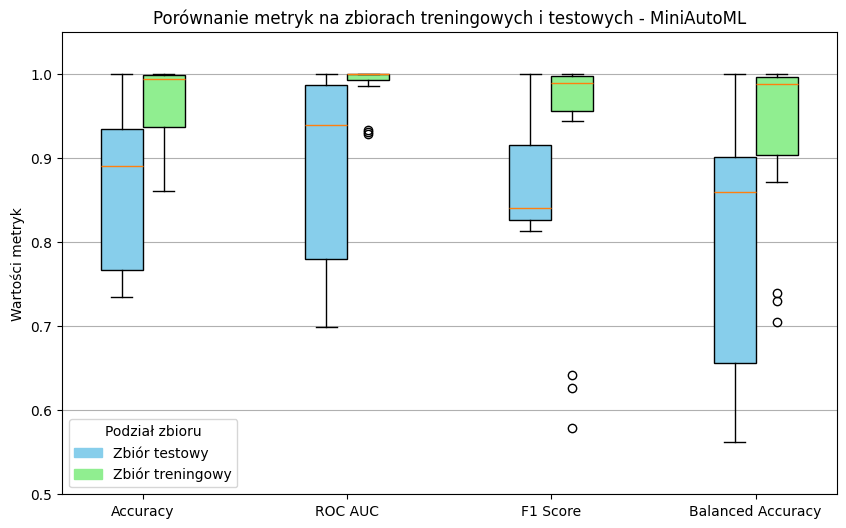

In [ ]:
import matplotlib.pyplot as plt

scores_raw = scores[["accuracy_test", "accuracy_train", "roc_auc_test", "roc_auc_train", "f1_test", "f1_train", "balanced_accuracy_test", "balanced_accuracy_train"]]
data = [scores_raw[col] for col in scores_raw.columns]


positions = []
gap = 1.0
width = 0.35
for i in range(4):
    positions.append(i*2*width + i*gap)
    positions.append(i*2*width + i*gap + width)

plt.figure(figsize=(10, 6))


bp = plt.boxplot(data, positions=positions, widths=width, patch_artist=True)


colors = ['skyblue', 'lightgreen']*4
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

pair_positions = [np.mean(positions[i*2:i*2+2]) for i in range(4)]
plt.xticks(pair_positions, ['Accuracy', 'ROC AUC', 'F1 Score', 'Balanced Accuracy'])

import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(color='skyblue', label='A'),
    mpatches.Patch(color='lightgreen', label='B')
]
plt.legend(handles=legend_handles, title='Podział zbioru', labels=['Zbiór testowy', 'Zbiór treningowy'])

plt.ylabel('Wartości metryk')
plt.title('Porównanie metryk na zbiorach treningowych i testowych - MiniAutoML')
plt.grid(axis='y')
plt.ylim(0.5, 1.05)
plt.savefig("mini_auto_ml.png")
plt.show()
